In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [13]:
class Layer:
    def __init__(self, nodes_in, nodes_out, activation):
        self.nodes_in = nodes_in
        self.nodes_out = nodes_out
        self.activation = activation
        
        self.prev_layer = None
        self.next_layer = None
        self.input = None
        self.output = None

        self.weights = np.random.rand(self.nodes_out, self.nodes_in) - 0.5
        self.biases = np.random.rand(self.nodes_out, 1) - 0.5
        self.velocities = np.zeros((self.nodes_out, self.nodes_in))
        
    def forward(self, input):
        self.Z = self.weights.dot(input) + self.biases
        self.A = activation_functions(self.Z, False, self.activation)
        self.output = self.A
        
        if self.next_layer: self.next_layer.input = self.output
        return self.output
    
    def backward(self, lr, output_error, one_hot_Y=None, momentum = 1):
        if self.next_layer == None:
            output_error = self.A - one_hot_Y
            dZ = output_error
        else:
            dA = self.next_layer.weights.T.dot(output_error)
            dZ = dA * activation_functions(self.Z, True, self.activation)
            
        # Finding gradient wrt weights and biases    
        self.dW = (1 / self.A.shape[1]) * dZ.dot(self.input.T)
        self.db = (1 / self.A.shape[1]) * np.sum(dZ)
        
        # Updating weights and biases
        self.velocities = momentum * self.velocities + lr * self.dW
        self.weights -= self.velocities
        self.biases -= lr * self.db
        
        return dZ

In [14]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
        if len(self.layers) > 1:
            self.layers[-2].next_layer = self.layers[-1]
            self.layers[-1].prev_layer = self.layers[-2]
        
    def forward_prop(self, input, i=0):
        if self.layers[i].next_layer == None:
            return self.layers[i].forward(input)
        return self.forward_prop(self.layers[i].forward(input), i+1)
    
    def backward_prop(self, lr, Y, dZ=0):
        for i in self.layers[::-1]:
            if i.next_layer==None:
                one_hot_Y = one_hot(Y)
                dZ = i.backward(lr, dZ, one_hot_Y)
            else:
                dZ = i.backward(lr, dZ)
                
    def get_predictions(self):
        return np.argmax(self.layers[-1].A, 0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size
    
    def sparse_categorical_crossentropy(self, y_true, y_pred, grad=False):
        y_pred = np.clip(y_pred, np.finfo(float).eps, 1.0 - np.finfo(float).eps)
        num_classes = y_pred.shape[1]
        y_true = y_true.astype(int)
        neg_log_likelihood = -np.sum(y_true * np.log(y_pred), axis=1)
        average_loss = np.mean(neg_log_likelihood)
        if not grad:
            return average_loss
        gradients = (y_pred - y_true) / len(y_true)
        return average_loss, gradients

    
    def gradient_descent(self, X, Y, lr, iterations):
        for i in range(iterations):
            A_final = self.forward_prop(X)
            loss = self.sparse_categorical_crossentropy(one_hot(Y), A_final, False)
            dZ = self.sparse_categorical_crossentropy(one_hot(Y), A_final, True)
            self.backward_prop(lr, Y, dZ)
            if i % 10 == 0:
                print("Iteration: ", i, end=', ')
                predictions = self.get_predictions()
                accuracy = self.get_accuracy(predictions, Y)
                print("Loss: ", loss, end=', ')
                print('Accuracy: ', round(accuracy*100, 2), end='%, ')
                
                dev_predictions = ann.make_predictions(X_test)
                accuracy = ann.get_accuracy(dev_predictions, y_test)
                print('Test Data Accuracy: ', round(accuracy*100, 2), end='%\n')

    def make_predictions(self, X):
        A_final = self.forward_prop(X)
        predictions = self.get_predictions()
        return predictions

In [15]:
def activation_functions(Z, deriv, activation):
    def relu(Z, deriv):
        if deriv:
            return Z > 0
        return np.maximum(Z, 0)

    def sigmoid(Z, deriv):
        if deriv:
            return sigmoid(Z, False) * (1 - sigmoid(Z, False))
        Z = np.clip(Z, -500, 500)
        return 1/(1+np.exp(-Z))

    def softmax(Z, deriv):
        exps = np.exp(Z - Z.max())
        if deriv:
             return softmax(Z, False) * (1 - softmax(Z, False))
        Z = np.clip(Z, -500, 500)
        exps = np.exp(Z - np.max(Z, axis=0))
        sum_exps = np.sum(exps, axis=0)
        softmax_output = exps / (sum_exps + np.finfo(float).eps)
        return softmax_output
    
    def tanh(Z, deriv):
        if deriv:
            return 1 - np.tanh(Z) ** 2
        return np.tanh(Z)
    
    activation_outputs = {
        'relu': relu(Z, deriv),
        'sigmoid': sigmoid(Z, deriv),
        'softmax': softmax(Z, deriv),
        'tanh': tanh(Z, deriv)
    }   
    return activation_outputs[f'{activation}']


def one_hot(Y):
    one_hot_Y = np.zeros((len(Y), 10))
    one_hot_Y[np.arange(len(Y)), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [16]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train=y_train.reshape(-1,)
y_test=y_test.reshape(-1,)

X_test_dupl = X_test.copy()

X_train = X_train.reshape(-1, 32*32*3).T / 255.0
X_test = X_test.reshape(-1, 32*32*3).T / 255.0

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3072, 50000) (3072, 10000) (50000,) (10000,)


In [23]:
lr = 0.2
momentum = 1
num_hidden = 3
sizes = (100,100,50)
activation = ('tanh', 'sigmoid', 'sigmoid')
loss = 'sce'
batch_size = 20
anneal = True
epochs = 500
# X_train, y_train, X_test, y_test already given

ann = NeuralNetwork()
def train(lr, momentum, num_hidden, sizes, activation, loss, batch_size, anneal, epochs, X_train, y_train, X_test, y_test):
    layer1 = Layer(3*32*32, sizes[0], activation[0])
    ann.add_layer(layer1)
    layer1.input = X_train
    for i in range(1, num_hidden):
        ann.add_layer(Layer(sizes[i-1], sizes[i], activation[i]))
    ann.add_layer(Layer(sizes[-1], 10, 'softmax'))
                  
    ann.forward_prop(X_train)
    ann.backward_prop(lr, y_train)

    ann.gradient_descent(X_train, y_train, lr=lr, iterations=epochs)

In [24]:
train(lr, momentum, num_hidden, sizes, activation, loss, batch_size, anneal, epochs, X_train, y_train, X_test, y_test)

Iteration:  0, Loss:  12590.588070299393, Accuracy:  11.77%, Test Data Accuracy:  11.74%
Iteration:  10, Loss:  12692.100734324018, Accuracy:  13.2%, Test Data Accuracy:  10.74%
Iteration:  20, Loss:  11599.219554476937, Accuracy:  13.63%, Test Data Accuracy:  14.56%
Iteration:  30, Loss:  10842.56097413786, Accuracy:  17.64%, Test Data Accuracy:  18.87%
Iteration:  40, Loss:  10634.983219944219, Accuracy:  18.89%, Test Data Accuracy:  18.91%
Iteration:  50, Loss:  10328.34165816296, Accuracy:  22.07%, Test Data Accuracy:  21.36%
Iteration:  60, Loss:  10255.938619691213, Accuracy:  22.84%, Test Data Accuracy:  23.52%
Iteration:  70, Loss:  10065.33699541297, Accuracy:  25.66%, Test Data Accuracy:  25.78%
Iteration:  80, Loss:  9975.192093318603, Accuracy:  24.88%, Test Data Accuracy:  25.32%
Iteration:  90, Loss:  9839.387220328863, Accuracy:  26.88%, Test Data Accuracy:  26.58%
Iteration:  100, Loss:  9729.304885321744, Accuracy:  28.3%, Test Data Accuracy:  28.11%
Iteration:  110, L

In [25]:
LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck']

In [26]:
pred = ann.make_predictions(X_test)
print(pred, y_test)

[5 1 8 ... 5 6 7] [3 8 8 ... 5 1 7]


In [27]:
idx_correct = []
idx_incorrect = []

for idx in range(len(pred)):
    if pred[idx] == y_test[idx]:
        idx_correct.append(idx)
    else:
        idx_incorrect.append(idx)

In [28]:
print('Accuracy on test data: ', len(idx_correct)/100, '%')

Accuracy on test data:  36.88 %


Label:  ship
Prediction:  ship


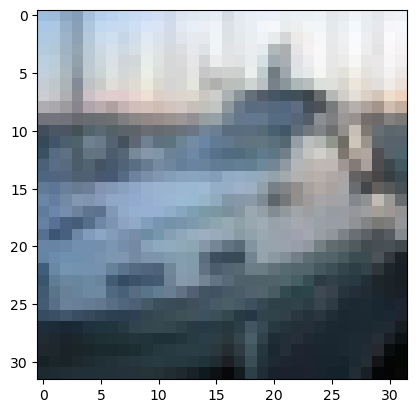

In [29]:
idx = idx_correct[0]
plt.imshow((X_test * 255.0).T[idx].reshape(32, 32, 3).astype('uint8'))
print('Label: ', LABELS[y_test[idx]])
print('Prediction: ', LABELS[pred[idx]]) 

Label:  cat
Prediction:  dog


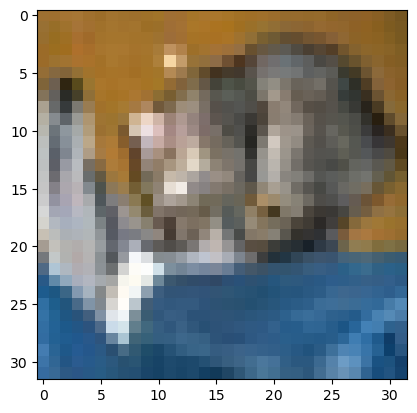

In [30]:
idx = idx_incorrect[0]
plt.imshow((X_test * 255.0).T[idx].reshape(32, 32, 3).astype('uint8'))
print('Label: ', LABELS[y_test[idx]])
print('Prediction: ', LABELS[pred[idx]]) 